In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial, cache
from copy import deepcopy
from pathlib import Path
from typing import Optional, Callable

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import numpy as np

import pandas as pd 

import scipy
import scipy.stats
import scipy.integrate

import torch
import torch.distributions
import torch.nn.functional as F

import math

import pytorch_lightning as pl

import sbi
import sbi.analysis as analysis
from sbi.inference import SNRE_A, SNRE_B, prepare_for_sbi
from sbi.utils.get_nn_models import classifier_nn

import cnre
from corner import corner

import sklearn

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
color_truth = "orange"
color_gilles = "blue"
color_durkan = "green"

In [5]:
num_total_samples = 40_000
num_posterior_samples = 100_000

train_kwargs = dict(
    training_batch_size=1_000,
    learning_rate=3e-4,
    validation_fraction=0.25,
    stop_after_epochs=2 ** 31 - 1,
    max_num_epochs=80,
    # max_num_epochs=30,
)

classifier_kwargs = dict(
    model='mlp', 
    # model='resnet', 
    hidden_features=128, 
    # num_blocks=2,
    # dropout_probability=0.0,
    # use_batch_norm=True
)
sample_with = "rejection"

device = "cpu"

In [6]:
dimension = 1

if True:
    low = -torch.ones(dimension).mul(3.).sqrt().to(device)
    # low = -torch.zeros(dimension).to(device) + 0.001
    high = torch.ones(dimension).mul(3.).sqrt().to(device)
    limits = torch.stack([low.cpu(), high.cpu()], dim=-1).numpy()
    
    prior = sbi.utils.BoxUniform(low=low, high=high, device=device)
else:
    v = torch.ones(dimension).mul(4.).to(device)
    limits = torch.stack([-v, v], dim=-1).numpy()
    
    # prior = torch.distributions.Normal(loc=torch.zeros(1, device=device), scale=torch.ones(1, device=device))
    prior = torch.distributions.MultivariateNormal(loc=torch.zeros(dimension, device=device), covariance_matrix=torch.eye(dimension, device=device) )
    
task = cnre.Gaussian(scale=0.1)
# task = cnre.Parabola(scale=0.9)
# simulator, prior = prepare_for_sbi(expo_simulator, prior)
simulator, prior = prepare_for_sbi(task.simulate, prior)

# true_theta = torch.zeros(dimension).to(device).unsqueeze(0)
true_theta = torch.ones(dimension).to(device).unsqueeze(0)
observation = simulator(true_theta)

theta = prior.sample((num_total_samples,)).to(device)
x = simulator(theta).to(device)

## ratio estimation

In [7]:
get_classifier = classifier_nn(**classifier_kwargs)

inference = SNRE_A(
    prior, 
    classifier=get_classifier,
    device=device,
)
_ = inference.append_simulations(theta, x).train(**train_kwargs)

inference._neural_net.load_state_dict(inference._best_model_state_dict)
density_estimator_nrea = deepcopy(inference._neural_net)

posterior = inference.build_posterior(
    density_estimator_nrea,
    sample_with=sample_with,
)

 Training neural network. Epochs trained: 81

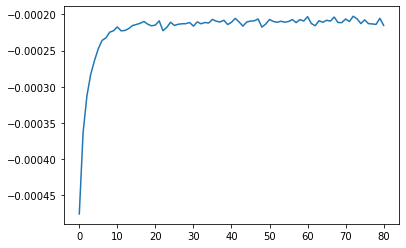

In [8]:
plt.plot(inference.summary["validation_log_probs"])

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

/home/ben/sci/cnre/remote/sbi/sbi/analysis/plot.py:176: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/torch/csrc/utils/tensor_new.cpp:210.)
  limits = torch.as_tensor(limits)


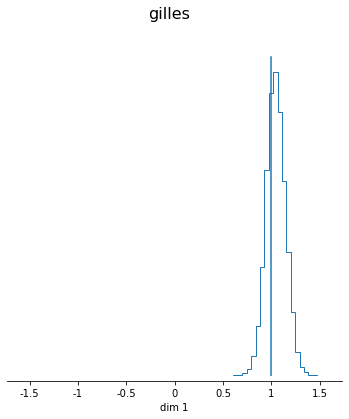

In [9]:
samples_gilles = posterior.sample((num_posterior_samples,), x=observation.cpu())
name = "gilles"
fig, _ = analysis.pairplot(
    samples_gilles.cpu().numpy(), 
    figsize=(6,6), 
    points=true_theta.cpu().numpy(),
    title=name,
    limits=limits,
)

## durkan

In [10]:
get_classifier = classifier_nn(**classifier_kwargs)

inference = SNRE_B(
    prior, 
    classifier=get_classifier,
    device=device,
)
_ = inference.append_simulations(theta, x).train(num_atoms=25, **train_kwargs)

inference._neural_net.load_state_dict(inference._best_model_state_dict)
density_estimator_nreb = deepcopy(inference._neural_net)

posterior = inference.build_posterior(
    density_estimator_nreb,
    sample_with=sample_with,
)

 Training neural network. Epochs trained: 81

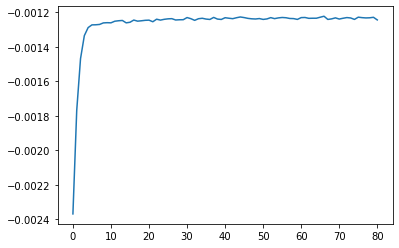

In [11]:
plt.plot(inference.summary["validation_log_probs"])

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

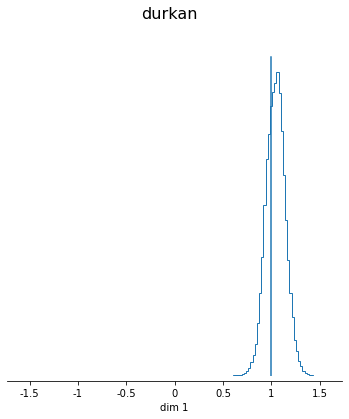

In [12]:
samples_durkan = posterior.sample((num_posterior_samples,), x=observation.cpu())
name = "durkan"
fig, _ = analysis.pairplot(
    samples_durkan.cpu().numpy(), 
    figsize=(6,6), 
    points=true_theta.cpu().numpy(),
    title=name,
    limits=limits,
)

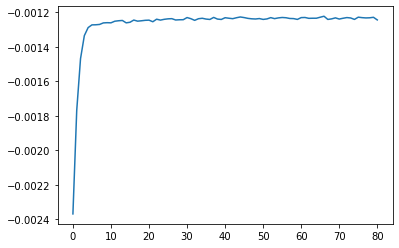

In [13]:
plt.plot(inference.summary["validation_log_probs"])

## posteriors

In [29]:
ll = lambda theta: task.log_likelihood(theta, observation).exp()
evidence, _ = scipy.integrate.quad(ll, low.item(), high.item())
tt = prior.sample((num_posterior_samples,))

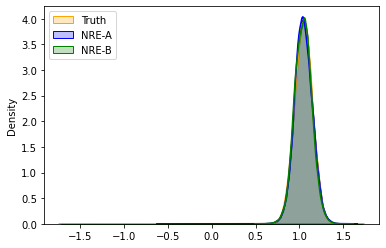

In [32]:
kwargs = dict(
    bins=100,
    binrange=(low.item(), high.item()), 
    stat="density",
    kde=True,
    element="poly",
    alpha=0.25,
)

fig, ax = plt.subplots()

sns.histplot(
    x=tt.squeeze().numpy(), 
    weights=(ll(tt) / evidence).squeeze().numpy(),
    color=color_truth,
    label="Truth",
    **kwargs,
)
sns.histplot(
    x=samples_gilles.squeeze().numpy(),
    color=color_gilles,
    label="NRE-A",
    **kwargs,
)
sns.histplot(
    x=samples_durkan.squeeze().numpy(),
    color=color_durkan,
    label="NRE-B",
    **kwargs,
)
ax.legend()

## likelihood

In [16]:
def get_weigh_function(density_estimator: torch.nn.Module, theta_o: torch.Tensor) -> Callable:
    def weigh(x):
        with torch.no_grad():
            return density_estimator([theta_o.expand(x.shape[0], -1).to(device), x.to(device)]).exp().to(device=device)
    return weigh

In [17]:
nrea = get_weigh_function(density_estimator_nrea, true_theta)
nreb = get_weigh_function(density_estimator_nreb, true_theta)

In [18]:
# # corner
# fig = corner(
#     x_likelihood.squeeze().numpy(),
#     range=limits,
# )
# _ = corner(
#     x_marginal.squeeze().numpy(),
#     weights=nrea(x_marginal).squeeze().numpy(),
#     color="red",
#     range=limits,
#     fig=fig,
# )
# _ = corner(
#     x_marginal.squeeze().numpy(),
#     weights=nreb(x_marginal).squeeze().numpy(),
#     color="blue",
#     range=limits,
#     fig=fig,
# )

In [19]:
# x_likelihood = simulator(true_theta.expand((num_posterior_samples, -1))).to(device)
# x_marginal = simulator(prior.sample((num_posterior_samples,))).to(device)

# fig, ax = plt.subplots(figsize=(7,7))
# kwargs = dict(
#     bins=1_000, 
#     binrange=limits.squeeze().tolist(),
#     # kde=True, 
#     ax=ax,
#     stat="density",
#     alpha=0.25,
#     element="poly",
# )
# sns.histplot(x=x_likelihood.squeeze().numpy(), color="orange", **kwargs)
# # sns.histplot(
# #     x=x_marginal.squeeze().numpy(),
# #     weights=task.log_likelihood(true_theta.expand(num_posterior_samples, -1).squeeze(), x_marginal.squeeze()).exp(),
# #     color="red", 
# #     **kwargs
# # )
# sns.histplot(
#     x=x_marginal.squeeze().numpy(), 
#     weights=nrea(x_marginal).squeeze().numpy(), 
#     color="blue", 
#     **kwargs
# )
# sns.histplot(
#     x=x_marginal.squeeze().numpy(),
#     weights=nreb(x_marginal).squeeze().numpy(),
#     color="green",
#     **kwargs
# )
# plt.xlim(*limits.squeeze().tolist())

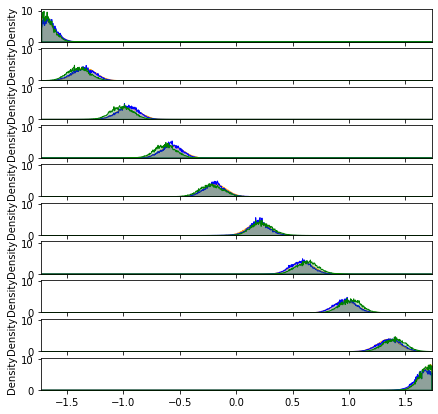

In [20]:
to_check = torch.linspace(low.item(), high.item(), 10)
fig, axes = plt.subplots(nrows=len(to_check), figsize=(7,7), sharex=True, sharey=True)

for tt, ax in zip(to_check, axes.flatten()):
    tt = tt.unsqueeze(-1)

    x_likelihood = simulator(tt.expand((num_posterior_samples, -1))).to(device)
    x_marginal = simulator(prior.sample((num_posterior_samples,))).to(device)

    
    kwargs = dict(
        bins=1_000, 
        binrange=limits.squeeze().tolist(),
        # kde=True, 
        ax=ax,
        stat="density",
        alpha=0.25,
        element="poly",
    )
    sns.histplot(x=x_likelihood.squeeze().numpy(), color=color_truth, **kwargs)
    # sns.histplot(
    #     x=x_marginal.squeeze().numpy(),
    #     weights=task.log_likelihood(true_theta.expand(num_posterior_samples, -1).squeeze(), x_marginal.squeeze()).exp(),
    #     color="red", 
    #     **kwargs
    # )
    sns.histplot(
        x=x_marginal.squeeze().numpy(), 
        weights=get_weigh_function(density_estimator_nrea, tt)(x_marginal).squeeze().numpy(), 
        color=color_gilles, 
        **kwargs
    )
    sns.histplot(
        x=x_marginal.squeeze().numpy(),
        weights=get_weigh_function(density_estimator_nreb, tt)(x_marginal).squeeze().numpy(),
        color=color_durkan,
        **kwargs
    )
    plt.xlim(*limits.squeeze().tolist())

## importance sampling diagnostic

In [21]:
class WeightedLossClassifier(pl.LightningModule):
    def __init__(self, weigh: Callable, ndim: int):
        super().__init__()
        self.weigh = weigh
        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(ndim, 10*ndim),
            torch.nn.ReLU(),
            torch.nn.Linear(10*ndim, 10*ndim),
            torch.nn.ReLU(),
            torch.nn.Linear(10*ndim, 1),
        )

    def forward(self, x):
        return self.classifier(x).sigmoid()

    def _get_loss(self, batch, batch_idx):
        x_ind, x_dep = batch
        # ind goes to zero, dep goes to one
        t = torch.cat(
            [torch.zeros((x_ind.shape[0], 1), device=self.device), torch.ones((x_dep.shape[0], 1), device=self.device)],
            dim=0,
        )
        y_ind = self.classifier(x_ind)
        y_dep = self.classifier(x_dep)
        y = torch.cat([y_ind, y_dep], dim=0)
        w = torch.cat([self.weigh(x_ind), torch.ones((x_dep.shape[0], 1), device=self.device)], dim=0)
        return F.binary_cross_entropy_with_logits(y, t, w)
    
    def training_step(self, batch, batch_idx):
        loss = self._get_loss(batch, batch_idx)
        self.log("train_loss", loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        loss = self._get_loss(batch, batch_idx)
        self.log("val_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [22]:
def importance_diagnostic(
    X: torch.Tensor,
    Y: torch.Tensor,
    weigh: Callable,
    seed: int = 1,
    n_folds: int = 5,
    scoring: str = "accuracy",
    z_score: bool = True,
    noise_scale: Optional[float] = None,
) -> torch.Tensor:
    """X - independent, Y - dependent, classifier returns prob sample is dependent.
    
    Classifier-based 2-sample test returning accuracy

    Trains classifiers with N-fold cross-validation [1]. Scikit learn MLPClassifier are
    used, with 2 hidden layers of 10x dim each, where dim is the dimensionality of the
    samples X and Y.

    Args:
        X: Sample 1
        Y: Sample 2
        seed: Seed for sklearn
        n_folds: Number of folds
        z_score: Z-scoring using X
        noise_scale: If passed, will add Gaussian noise with std noise_scale to samples

    References:
        [1]: https://scikit-learn.org/stable/modules/cross_validation.html
    """
    if z_score:
        X_mean = torch.mean(X, dim=0)
        X_std = torch.std(X, dim=0)
        X = (X - X_mean) / X_std
        Y = (Y - X_mean) / X_std

    if noise_scale is not None:
        X += noise_scale * torch.randn(X.shape)
        Y += noise_scale * torch.randn(Y.shape)

    X = X.cpu()
    Y = Y.cpu()

    ndim = X.shape[1]

    # data = np.concatenate((X, Y))
    # target = np.concatenate(
    #     (
    #         np.zeros((X.shape[0],)),
    #         np.ones((Y.shape[0],)),
    #     )
    # )
    
    validation_percentage = 0.1
    dataset = torch.utils.data.TensorDataset(X, Y)  # for this X is ind and Y is dep
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, 
        [math.floor(len(dataset) * (1 - validation_percentage)), math.ceil(len(dataset) * validation_percentage)],
    )
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

    clf = WeightedLossClassifier(weigh, ndim)
    trainer = pl.Trainer(max_epochs=100)
    trainer.fit(clf, train_dataloader, test_dataloader)
    return clf
    
    # shuffle_k_fold = KFold(n_splits=n_folds, shuffle=True, random_state=seed)
    # shuffle_k_fold.get_n_splits()
    
#     scores = cross_val_score(clf, data, target, cv=shuffle, scoring=scoring)

#     scores = np.asarray(np.mean(scores)).astype(np.float32)
#     return torch.from_numpy(np.atleast_1d(scores))

In [23]:
def draw_ind_and_dep_samples(n: int, theta_o: torch.Tensor):
    x_ind = simulator(prior.sample((n,)))
    x_dep = simulator(theta_o.expand(n, -1))
    return (x_ind, torch.zeros((n,))), (x_dep, torch.ones((n,)))

In [24]:
(x_ind, _), (x_dep, _) = draw_ind_and_dep_samples(10_000, true_theta)
aaa = importance_diagnostic(x_ind, x_dep, nrea)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ben/sci/cnre/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1812: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=3)`.
  rank_zero_warn(

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 141   
------------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/ben/sci/cnre/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ben/sci/cnre/env/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ben/sci/cnre/env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (36) is smaller than the logging interval Trainer(lo

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [25]:
bbb = importance_diagnostic(x_ind, x_dep, nreb)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | classifier | Sequential | 141   
------------------------------------------
141       Trainable params
0         Non-trainable params
141       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

#### weighted ROC
https://mran.microsoft.com/snapshot/2017-06-26/web/packages/WeightedROC/vignettes/Definition.pdf  

In [26]:
(x_ind, y_ind), (x_dep, y_dep) = draw_ind_and_dep_samples(num_posterior_samples, true_theta)
x = torch.cat([x_ind, x_dep])
y = torch.cat([y_ind, y_dep])
w_a = torch.cat([nrea(x_ind), torch.ones(x_dep.shape[0], 1)])
w_b = torch.cat([nreb(x_ind), torch.ones(x_dep.shape[0], 1)])

with torch.no_grad():
    fpr_a, tpr_a, thresholds_a = sklearn.metrics.roc_curve(y, aaa(x).squeeze().sigmoid(), sample_weight=w_a.squeeze())
    fpr_b, tpr_b, thresholds_b = sklearn.metrics.roc_curve(y, bbb(x).squeeze().sigmoid(), sample_weight=w_b.squeeze())
    # fpr_a, tpr_a, thresholds_a = sklearn.metrics.roc_curve(y, aaa(x).squeeze().sigmoid())
    # fpr_b, tpr_b, thresholds_b = sklearn.metrics.roc_curve(y, bbb(x).squeeze().sigmoid())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


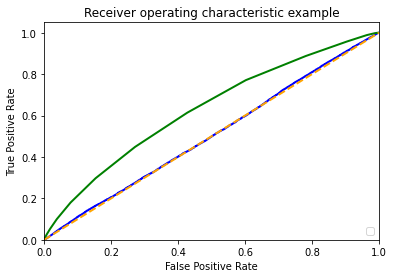

In [27]:
plt.figure()
lw = 2
plt.plot(
    fpr_a,
    tpr_a,
    color=color_gilles,
    lw=lw,
    # label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot(
    fpr_b,
    tpr_b,
    color=color_durkan,
    lw=lw,
    # label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color=color_truth, lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()